In [1]:
# Goal: Investigate directly nested sampling of tigerfit around diffusion peak including the E_thermal component
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
import tqdm
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit

In [2]:
ds = dataset.load_dataset('SN2019odp_phot')

In [3]:
# Params
texpl_range = (58712.48, 58716.38)
time_range = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+60)
prior_kwargs = {
    'vej_min': 9477,
    'vej_max': 12347,
    'gamma_trapped': False
}
time_valid = np.array([
    [58700, 58880],
    [59000, 59130]
])

In [4]:
sampler = tigerfit.nested_fitting(ds, time_range=time_range, prior_kwargs=prior_kwargs, texpl_range=texpl_range, time_valid=time_valid, include_e_thermal=True, nlive_init=8000)

  0%|          | 0/12000 [00:00<?, ?it/s]/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
100%|██████████| 12000/12000 [00:39<00:00, 305.33it/s]


In [5]:
sampler.run_nested(dlogz_init=0.1)
#sampler.run_nested()

21177it [1:45:59,  3.33it/s, batch: 7 | bound: 5159 | nc: 8 | ncall: 4413102 | eff(%):  0.480 | loglstar: -6.499 < -0.048 < -0.126 | logz: -11.352 +/-  0.186 | stop:  0.982]        


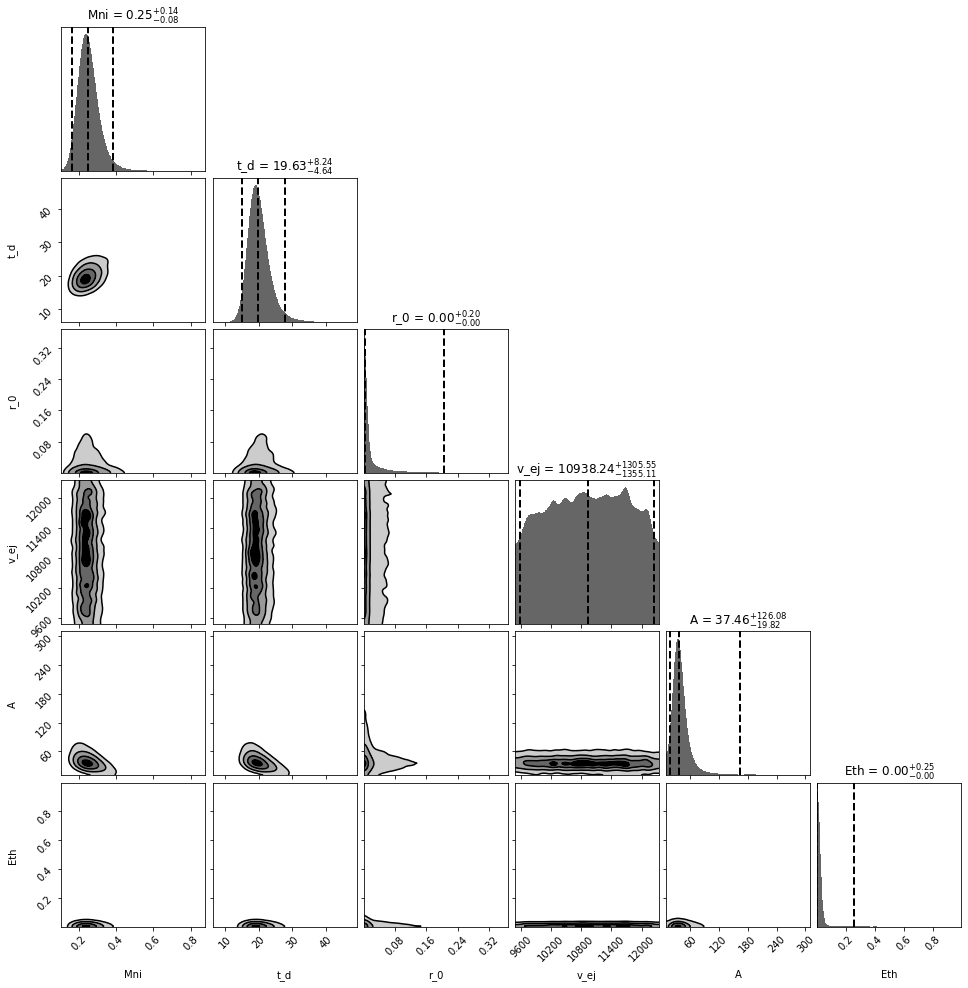

In [6]:
dyplot.cornerplot(sampler.results, labels=['Mni', 't_d', 'r_0', 'v_ej', 'A', 'Eth'], show_titles=True);

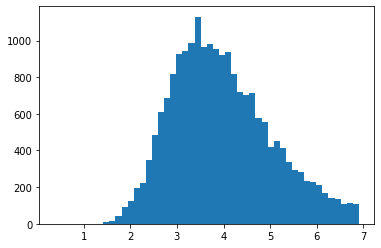

In [11]:
kappa = 0.05

results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
p = dyfunc.resample_equal(samples, weights)

day=86400.     #seconds in a day
year=3.15436e7 #seconds in a year
Msun=1.99e33   #solar mass in grams
c=2.99792458e10#speed of light
sb=5.67051e-5  #Stefan-Boltzmann constant
kms2cms=1.e5   #km/s in cm/s
r15=1.e15      #radii in units of 10^15cm
tni=8.8        #Ni-56 decay time-scale
tco=111.3      #Co-56 decay time-scale
eni=3.9e10     #Ni-56 decay specific energy generation rate
eco=6.8e9      #Co-56 decay specific energy generation rate
TH=5500.       #Hydrogen ionization temperature in K
A0=1.e12       #Radioactive decay model gamma-ray leakage parameter in 10^14 units (sec^2)
E51=1.e51      #Energy in units of 1 F.O.E. (10^51 erg)
L45=1.e45      #Luminosity in units of 10^45 erg/s
nmax=1000000   #Grid resolution for fallback accretion model integration

Mej = ((3./10.)*(13.8*c/kappa)*p[:,3]*kms2cms*(p[:,1]*day)**2)/Msun
# sigma-clip
mej_q95 = np.percentile(Mej, 95)
plt.hist(Mej[Mej < mej_q95], bins=50);

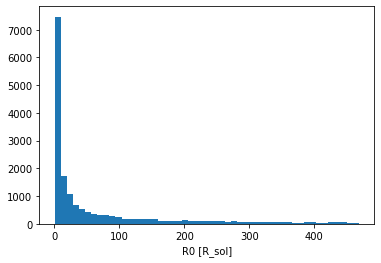

In [14]:
r0_q95 = np.percentile(p[:,2], 80)
plt.hist(p[:,2][p[:,2] < r0_q95]*r15/(1*u.Rsun.to(u.cm)), bins=50)
plt.xlabel('R0 [R_sol]');

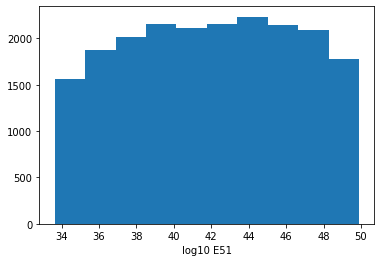

In [9]:
eth_q95 = np.percentile(p[:,5], 95)
plt.hist(np.log10(p[:,5][p[:,5] < eth_q95]*E51))
plt.xlabel('log10 E51');

<AxesSubplot:>

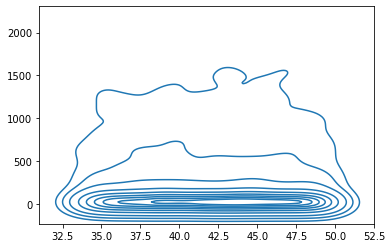

In [10]:
eth_q95 = np.percentile(p[:,5], 95)
r0_q95 = np.percentile(p[:,2], 95)
idx = np.logical_and(p[:,5] < eth_q95, p[:,2] < r0_q95)
#plt.hist2d(np.log10(p[:,5][idx]*E51), p[:,2][idx])
#plt.xlabel('log10 E51');
seaborn.kdeplot(x=np.log10(p[:,5][idx]*E51), y=p[:,2][idx]*r15/(1*u.Rsun.to(u.cm)))